# Notebook to check which type of model is the most informative

Based on the data a beta family and a normative distrubtion will be selected.

Three types of models will be selected. 
1) Gaussian (pre ran)
2) Beta logit with weakly informative priors
3) Beta logit with more informative priors

In [213]:
from nfact_id.functions.idp_functions import create_wide_df
import numpy as np
import bambi as bmb
import arviz as az
from decouple import config
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import os
os.environ["CPATH"] = "/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/v1"

## Get file paths

In [191]:
component_dir = os.path.join(config("base_dir"), "component_loadings", "hcp")
storage_dir = os.path.join(config("base_dir"), "group_tests")

## Pre-process data

In [192]:
df_wide = create_wide_df(os.path.join(component_dir, "G_component_loadings.csv"), os.path.join(component_dir, "W_component_loadings.csv"))
participant_info = pd.read_csv(os.path.join(component_dir, "participants_dr.csv"))
df_wide['group'] = participant_info['phenotype']

In [193]:
long_df = pd.melt(df_wide, id_vars=['subject', 'group'], var_name='component', value_name='value')
long_df['component_num'] = long_df['component'].str.extract(r'(\d+)').astype(int)
long_df = long_df.sort_values(by=['subject', 'component_num'])
long_df['comp_type'] = long_df['component'].apply(lambda x: 'Grey' if 'G_' in x else 'White')
long_df = long_df.drop(columns='component').reset_index(drop=True)

### Get Controls only

In [194]:
controls = long_df[long_df['group'].str.contains("Control")].reset_index(drop=True)
controls_grey = controls[controls['comp_type'].str.contains("Grey")]
controls_white = controls[controls['comp_type'].str.contains("White")]

## The Models

## The two beta models

In [195]:
model_ctrl_white_weak_priors_beta = bmb.Model(
    "value ~ 0 + component_num + (1 | subject)",
    data=controls_white,
    family="beta",
    categorical=['subject', 'component_num'],
)

In [196]:
model_ctrl_white_weak_priors_beta

       Formula: value ~ 0 + component_num + (1 | subject)
        Family: beta
          Link: mu = logit
  Observations: 16200
        Priors: 
    target = mu
        Common-level effects
            component_num ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
                0.
             0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
             0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
             0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
             0. 0. 0. 0.], sigma: [25.12594538 25.12594538 25.12594538 25.12594538 25.12594538 25.12594538
             25.12594538 25.12594538 25.12594538 25.12594538 25.12594538 25.12594538
             25.12594538 25.12594538 25.12594538 25.12594538 25.12594538 25.12594538
             25.12594538 25.12594538 25.12594538 25.12594538 25.12594538 25.12594538
             25.12594538 25.12594538 25.12594538 25.12594538 25.1

In [197]:
model_ctrl_white_informed_priors_beta = bmb.Model(
    "value ~ 0 + component_num + (1 | subject)",
    data=controls_white,
    family="beta",
    categorical=['subject', 'component_num'],
    priors={
        "component_num": bmb.Prior("Normal", mu=0, sigma=1), # More informative sigma
        "1|subject": bmb.Prior("Normal", mu=0.0, sigma=bmb.Prior("HalfNormal", sigma=0.5)),
    }

)

In [198]:
model_ctrl_white_informed_priors_beta

       Formula: value ~ 0 + component_num + (1 | subject)
        Family: beta
          Link: mu = logit
  Observations: 16200
        Priors: 
    target = mu
        Common-level effects
            component_num ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
        
        Auxiliary parameters
            kappa ~ HalfCauchy(beta: 1.0)

In [199]:
idata_ctrl_weak_priors_beta = model_ctrl_white_weak_priors_beta.fit(tune=4000, draw=4000, cores=4, chains=4, mp_ctx="spawn", random_seed=1234, target_accept=0.98, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [value_kappa, component_num, 1|subject_sigma, 1|subject_offset]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 858 seconds.


In [200]:
idata_ctrl_informed_priors_beta = model_ctrl_white_informed_priors_beta.fit(tune=4000, draw=4000, cores=4, chains=4, mp_ctx="spawn", random_seed=1234, target_accept=0.98, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [value_kappa, component_num, 1|subject_sigma, 1|subject_offset]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 862 seconds.


In [201]:
az.summary(idata_ctrl_weak_priors_beta)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
component_num[0],0.777,0.027,0.728,0.829,0.001,0.000,2279.0,2447.0,1.0
component_num[1],1.128,0.029,1.075,1.183,0.001,0.000,2673.0,2764.0,1.0
component_num[2],1.155,0.029,1.098,1.209,0.001,0.001,3195.0,2733.0,1.0
component_num[3],0.329,0.025,0.282,0.377,0.001,0.000,2064.0,2291.0,1.0
component_num[4],1.005,0.027,0.955,1.057,0.000,0.000,3422.0,2643.0,1.0
...,...,...,...,...,...,...,...,...,...
1|subject[s0021],0.030,0.033,-0.034,0.091,0.001,0.001,3884.0,2730.0,1.0
1|subject[s0023],0.055,0.034,-0.015,0.115,0.001,0.001,3475.0,1801.0,1.0
1|subject[s0024],0.005,0.034,-0.057,0.070,0.001,0.001,3619.0,2616.0,1.0
1|subject[s0027],-0.006,0.033,-0.069,0.056,0.001,0.001,3320.0,2940.0,1.0


In [202]:
az.summary(idata_ctrl_informed_priors_beta)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
component_num[0],0.769,0.027,0.717,0.817,0.001,0.000,1956.0,2244.0,1.0
component_num[1],1.121,0.028,1.068,1.176,0.001,0.000,2226.0,2950.0,1.0
component_num[2],1.148,0.029,1.093,1.201,0.001,0.001,2546.0,2208.0,1.0
component_num[3],0.322,0.026,0.272,0.368,0.001,0.000,1691.0,2282.0,1.0
component_num[4],0.997,0.028,0.946,1.050,0.001,0.000,2581.0,2289.0,1.0
...,...,...,...,...,...,...,...,...,...
1|subject[s0021],0.035,0.033,-0.027,0.100,0.001,0.001,4010.0,2524.0,1.0
1|subject[s0023],0.060,0.033,0.001,0.122,0.001,0.001,3132.0,3047.0,1.0
1|subject[s0024],0.012,0.033,-0.054,0.070,0.001,0.001,3142.0,2666.0,1.0
1|subject[s0027],0.001,0.033,-0.058,0.064,0.001,0.001,2910.0,2020.0,1.0


## Fit Posterior

In [203]:
patients = long_df[~long_df['group'].str.contains("Control")]
white_ppc_df = patients[patients['comp_type'].str.contains("White")]

In [204]:
model_ctrl_white_weak_priors_beta.predict(idata=idata_ctrl_weak_priors_beta, data=white_ppc_df, kind="pps", sample_new_groups=True)
model_ctrl_white_informed_priors_beta.predict(idata=idata_ctrl_informed_priors_beta, data=white_ppc_df, kind="pps", sample_new_groups=True)

## Plot Energy

<Axes: xlabel='value'>

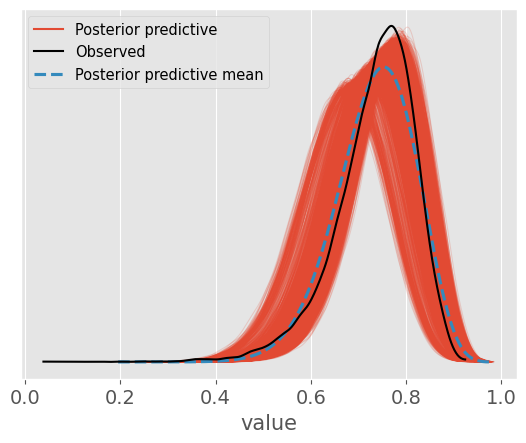

In [205]:
az.plot_ppc(idata_ctrl_weak_priors_beta)

<Axes: xlabel='value'>

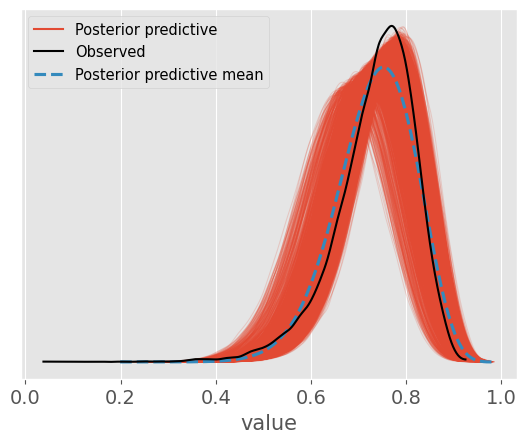

In [207]:
az.plot_ppc(idata_ctrl_informed_priors_beta)

## Compare all three models

In [208]:
idata_ctrl_white_gauss = az.from_netcdf(os.path.join(storage_dir, "normative_WM_fitted.nc"))

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

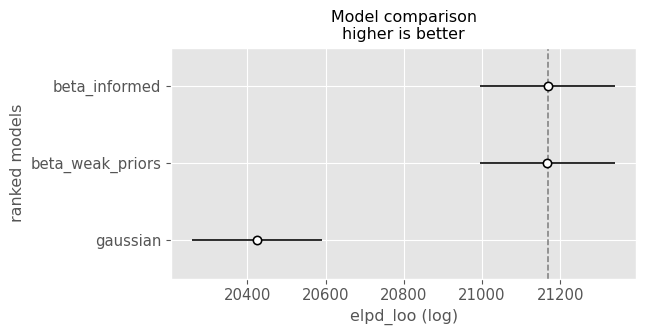

In [209]:
df = az.compare({"gaussian": idata_ctrl_white_gauss, "beta_weak_priors":idata_ctrl_weak_priors_beta, 'beta_informed': idata_ctrl_informed_priors_beta })
az.plot_compare(df)

## Which model has the least uncertainity

In [228]:
def param_uncertainty(idata, var_names=None):
    """
    Returns posterior SD and 95% HDI width for each parameter
    """
    summary = az.summary(idata, var_names=var_names, hdi_prob=0.95, round_to=3)
    summary['hdi_width'] = np.round(summary['hdi_97.5%'] - summary['hdi_2.5%'], 3)
    return summary[['mean', 'sd', 'hdi_97.5%', 'hdi_2.5%', 'hdi_width']]

In [233]:
def posterior_predictive_uncertainty(idata, obs_name='value'):
    """
    Returns mean predictive SD for each observation
    """
    ppc = idata.posterior_predictive[obs_name].stack(samples=("chain","draw")).values  # shape (n_samples, n_obs)
    obs_sd = np.std(ppc, axis=0)
    return pd.Series(obs_sd, name='ppc_sd')

In [232]:
gaussian_summary = param_uncertainty(idata_ctrl_white_gauss)

In [230]:
beta_weak_summary = param_uncertainty(idata_ctrl_weak_priors_beta)

In [231]:
beta_inform_summary = param_uncertainty(idata_ctrl_informed_priors_beta)

In [234]:
print("Gaussain hdi width: ", gaussian_summary['hdi_width'].mean())
print("beta weak hdi width:", beta_weak_summary['hdi_width'].mean())
print("beta informed hdi width:", beta_inform_summary['hdi_width'].mean())

Gaussain hdi width:  0.0855917619907686
beta weak hdi width: 0.0806864338751756
beta informed hdi width: 0.07842251153923338


In [239]:
gaussian_predictive = posterior_predictive_uncertainty(idata_ctrl_white_gauss)

In [236]:
beta_weak_predictive = posterior_predictive_uncertainty(idata_ctrl_weak_priors_beta)

In [237]:
beta_inform_predictive = posterior_predictive_uncertainty(idata_ctrl_informed_priors_beta)

In [240]:
print("PPD STD Gaussian: ", gaussian_predictive.mean())
print("PPD STD beta weak:", beta_weak_predictive.mean())
print("PPD STD beta informed:", beta_inform_predictive.mean())

PPD STD Gaussian:  0.08282146765352848
PPD STD beta weak: 0.08062912019496635
PPD STD beta informed: 0.08071467161185805


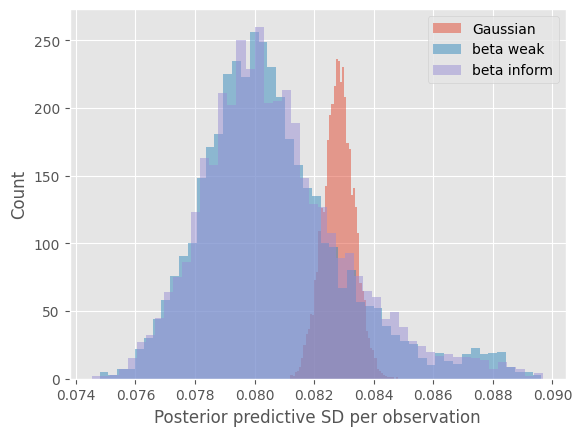

In [241]:
plt.hist(gaussian_predictive, bins=50, alpha=0.5, label='Gaussian')
plt.hist(beta_weak_predictive, bins=50, alpha=0.5, label='beta weak')
plt.hist(beta_inform_predictive, bins=50, alpha=0.5, label='beta inform')
plt.xlabel('Posterior predictive SD per observation')
plt.ylabel('Count')
plt.legend()
plt.show()